# Projet Data Science - Simulateur de DPE
## ENSAE Paris - 2A

Membres du groupe : 
- Wiam LACHQER , Amine RAZIG , Julien BOUDIER

Ce projet Python a été créé dans le but de fournir des visualisations variées des données et de mettre en place un simulateur de Diagnostic de Performance Energétique (DPE) à partir de la base de données de l'ADEME (Agence de la Transition Écologique).

## Objectifs du Projet

1. **Visualisations de Données :** Le projet propose différentes visualisations des données issues de la base de l'ADEME. Ces visualisations permettent une compréhension approfondie des caractéristiques énergétiques des logements.

2. **Simulateur de DPE :** Un simulateur de DPE a été développé en utilisant les données de l'ADEME. Ce simulateur permet d'estimer la performance énergétique d'un logement en fonction de divers paramètres.\

Ce simulateur fournit une estimation de la consommation énergétique et du volume des émissions de gaz à effet de serre par an et par m² en se basant sur les caractéristiques du logement. La base de données disponible sur le site contient 244 colonnes, on est amenés à choisir une trentaine de variables pour minimiser le coût de la modélisation. 
Pour ce faire, on s’est inspirés des simulateurs disponibles en ligne (comme celui-ci https://diagnosticdpe.com/estimer-DPE.php), les informations demandées doivent être accessibles pour le propriétaire. Certaines colonnes sont supprimées puisque le nombre de leurs valeurs manquantes est très élevé, ce qui n’est pas pratique pour la modélisation.


 Pour plus de détail sur l’étiquette DPE: https://www.choisir.com/energie/articles/199743/tout-savoir-sur-le-calcul-du-dpe

## Importation des librairies

In [2]:
#!pip install -q -r requirements.txt

In [4]:
import fetchdata
import eda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline




## Choix des variables et récupération des données

In [7]:
chosen_variables=['Etiquette_GES',
                  'Etiquette_DPE',
                  'Année_construction',
                  'Type_bâtiment',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Coordonnée_cartographique_X_(BAN)',     
                  'Coordonnée_cartographique_Y_(BAN)',
                  'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  'Coût_total_5_usages_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  'Coût_total_5_usages_énergie_n°3',
                  'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_installation_ECS',          
                  'Type_ventilation']
df = fetchdata.get_dpe(chosen_variables, size=50000)


Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Coût_total_5_usages_énergie_n°3      3974 non-null   float64
 1   Coût_total_5_usages_énergie_n°2      41048 non-null  float64
 2   Coût_total_5_usages_énergie_n°1      50000 non-null  float64
 3   Qualité_isolation_enveloppe          50000 non-null  object 
 4   Coût_total_5_usages                  50000 non-null  float64
 5   Emission_GES_5_usages                50000 non-null  float64
 6   Qualité_isolation_menuiseries        50000 non-null  object 
 7   Qualité_isolation_murs               50000 non-null  object 
 8   Etiquette_GES                        50000 non-null  object 
 9   Conso_5_usages_é_finale_énergie_n°1  50000 non-null  float64
 10  Conso_5_usages_é_finale_énergie_n°2  41048 non-null  float64
 11  Conso_5_usages_é_finale_éner

# Préparation des données

## Données manquantes

On choisit de supprimer les colonnes avec beaucoup de valeurs manquantes puis lignes avec des valeurs manquantes.

In [4]:
cols_to_drop = ['Coordonnée_cartographique_X_(BAN)',
                'Coordonnée_cartographique_Y_(BAN)',
                'N°_région_(BAN)',
                'Coût_total_5_usages_énergie_n°3',
                'Conso_5_usages_é_finale_énergie_n°3',
                'Type_ventilation',
                '_score']

df.drop(cols_to_drop, axis=1, inplace=True)

In [5]:
df = df.dropna(axis=0, how='any')

## Encodage des variables

On utilise pour encoder les variables textuelles :
    Le OneHotEncoding pour les variables dont les valeurs peuvent être classées (qualité de l'isolation par exemple)
    Le LabelEncoder pour les autres (type de bâtiment par exemple)

In [9]:
df = eda.label_encode(df, ["Qualité_isolation_enveloppe","Qualité_isolation_menuiseries","Qualité_isolation_murs","Etiquette_GES",
                       "Etiquette_DPE","Qualité_isolation_plancher_bas","Classe_altitude",])

df = eda.one_hot_encode(df, ["Type_installation_ECS","Type_bâtiment","Type_énergie_principale_chauffage",])


KeyError: "None of [Index(['Type_installation_ECS', 'Type_bâtiment',\n       'Type_énergie_principale_chauffage'],\n      dtype='object')] are in the [columns]"

In [7]:
print(df["Type_installation_ECS"].unique())

KeyError: 'Type_installation_ECS'

# Statistiques descriptives

In [ ]:
df.head()

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
0,342.0,1841.0,1,2702.0,5960.8,0,1,2,24645.6,10676.1,...,0,0,0,0,0,1,0,0,0,0
1,913.7,913.7,1,913.7,2152.0,2,1,3,9648.4,9648.4,...,0,0,0,0,0,0,0,0,1,0
4,2337.8,2337.8,1,2337.8,3672.5,2,1,3,17952.1,17952.1,...,0,0,0,0,0,0,0,0,1,0
6,812.4,812.4,1,812.4,794.8,2,1,2,12765.4,12765.4,...,0,0,0,0,0,1,0,0,0,0
7,1360.5,1360.5,1,1360.5,2673.1,2,1,3,10033.7,10033.7,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.describe()

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
count,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,...,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.00000,38830.000000
mean,947.285282,1350.240149,1.114087,1495.813778,3230.298802,1.704224,1.219676,2.731136,15888.509400,10107.369714,...,0.000386,0.000515,0.000386,0.119109,0.035540,0.504249,0.001545,0.205640,0.09503,0.000386
std,1249.730967,1305.770796,0.774051,1635.757786,4273.300348,0.955337,0.854265,1.267115,16419.186148,16307.756139,...,0.019651,0.022690,0.019651,0.323921,0.185141,0.499988,0.039279,0.404174,0.29326,0.019651
min,0.000000,0.000000,0.000000,65.000000,3.300000,0.000000,0.000000,0.000000,510.200000,9.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,198.700000,607.900000,1.000000,779.200000,1166.000000,1.000000,1.000000,2.000000,6676.000000,99.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,339.700000,1016.500000,1.000000,1179.450000,2219.350000,2.000000,1.000000,3.000000,11362.300000,1890.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
75%,1425.200000,1694.000000,1.000000,1806.000000,4047.100000,2.000000,1.000000,3.000000,19800.900000,15979.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
max,22472.000000,52025.000000,3.000000,101690.000000,242281.000000,3.000000,3.000000,6.000000,661057.900000,357835.700000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


La valeur maximale est souvent nettement supérieure au 3ème quartile. On décide de supprimer les outliers plutôt que de les imputer car on dispose d'une grande quantité de données.

In [ ]:
cleaned_df = eda.remove_outliers(df)

In [ ]:
eda.correlation(df)

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
Coût_total_5_usages_énergie_n°2,1.000000,0.841538,-0.038164,0.705191,0.677354,-0.145197,-0.127105,0.326743,0.814535,0.957116,...,-0.004684,-0.014157,0.004428,0.402883,-0.069698,-0.192042,-0.022578,-0.235849,0.192442,-0.009896
Coût_total_5_usages_énergie_n°1,0.841538,1.000000,-0.047970,0.940589,0.894180,-0.144270,-0.149394,0.398467,0.946380,0.821428,...,-0.015366,-0.020786,-0.001828,0.368057,0.036318,-0.165562,0.016555,-0.253905,0.170912,-0.000067
Qualité_isolation_enveloppe,-0.038164,-0.047970,1.000000,-0.041449,-0.042908,0.032573,0.105425,-0.072181,-0.050216,-0.034212,...,-0.002897,0.047978,-0.002897,-0.017734,-0.004931,0.028027,-0.010034,-0.016957,0.007830,-0.011363
Coût_total_5_usages,0.705191,0.940589,-0.041449,1.000000,0.936685,-0.108747,-0.120663,0.306928,0.903049,0.700877,...,-0.007159,-0.015161,-0.003209,0.287497,0.039196,-0.132143,0.016944,-0.198661,0.118985,0.002021
Emission_GES_5_usages,0.677354,0.894180,-0.042908,0.936685,1.000000,-0.105487,-0.121063,0.482052,0.894546,0.683889,...,-0.012846,-0.014788,0.054983,0.399038,-0.003069,-0.047748,0.006086,-0.215513,-0.036752,-0.009704
Qualité_isolation_menuiseries,-0.145197,-0.144270,0.032573,-0.108747,-0.105487,1.000000,0.130582,-0.144626,-0.137152,-0.149114,...,0.026664,0.012969,-0.007632,-0.082561,-0.037396,0.005732,-0.004978,0.134517,-0.062379,-0.021350
Qualité_isolation_murs,-0.127105,-0.149394,0.105425,-0.120663,-0.121063,0.130582,1.000000,-0.183357,-0.145925,-0.125356,...,-0.005055,0.014093,-0.005055,-0.094094,0.031240,-0.080269,0.001396,0.216379,-0.072537,-0.020397
Etiquette_GES,0.326743,0.398467,-0.072181,0.306928,0.482052,-0.144626,-0.183357,1.000000,0.405561,0.317408,...,-0.032029,-0.031014,0.050715,0.395208,0.078606,0.137373,0.013522,-0.264669,-0.241041,-0.032029
Conso_5_usages_é_finale_énergie_n°1,0.814535,0.946380,-0.050216,0.903049,0.894546,-0.137152,-0.145925,0.405561,1.000000,0.855405,...,-0.006695,-0.015289,0.029554,0.347881,-0.051705,-0.099516,-0.006251,-0.229304,0.070749,-0.009500
Conso_5_usages_é_finale_énergie_n°2,0.957116,0.821428,-0.034212,0.700877,0.683889,-0.149114,-0.125356,0.317408,0.855405,1.000000,...,-0.009555,-0.012037,0.036725,0.394858,-0.088263,-0.168826,-0.017797,-0.236195,0.156865,-0.006698


# Nuage de points

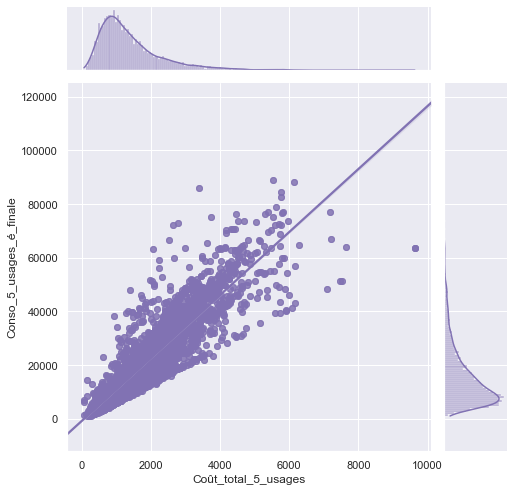

In [ ]:
eda.linreg_marg_dist(cleaned_df,"Coût_total_5_usages","Conso_5_usages_é_finale")

# Détection des valeurs manquantes et data pre-processing

La base de données contient plusieurs colonnes qu’on peut utiliser comme variables pour prédire la consommation de l’énergie par m², un nettoyage et un encodage de données sont alors nécessaires pour pouvoir sélectionner les colones à utiliser et avoir des données intérprétables par les modèles de machine learning (régression linéaire, XGBoost, CATBoost).

Le plan de ce qui suit:
- Importation des données.
- Suppression des colonnes dont plus de 60% de leurs valeurs sont manquantes.
- Analyse des corrélations entre les variables continues et de leurs distribution.
- Traitement des valeurs aberrantes 
- Visualisation et encodage des variables catégorielles
- Utilisation de la régularisation de Lasso pour sélectionner les variables explicatives les plus signifivcatives

## Importation des données

In [1]:
import fetchdata

chosen_variables=['Type_énergie_n°1',
                  'Type_énergie_n°2',
                  'Type_énergie_n°3',
                  'Etiquette_GES',
                  'Etiquette_DPE',
                  #'Année_construction',
                  'Type_bâtiment',
                  'Période_construction',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Zone_climatique_',
                  #'Nom__commune_(BAN)',
                  #'Coordonnée_cartographique_X_(BAN)',     
                  #'Coordonnée_cartographique_Y_(BAN)',
                  #'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  #'Coût_total_5_usages_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  #'Coût_total_5_usages_énergie_n°3',
                  'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_installation_ECS',
                  'Type_installation_solaire',
                  'Surface_climatisée',               
                  'Type_ventilation',
                  'Protection_solaire_exterieure_(0/1)',
                  'Isolation_toiture_(0/1)',
                  'Indicateur_confort_été']

df1 = fetchdata.get_dpe(chosen_variables, size =150000)

Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations
Fetched 60000 observations
Fetched 70000 observations
Fetched 80000 observations
Fetched 90000 observations
Fetched 100000 observations
Fetched 110000 observations
Fetched 120000 observations
Fetched 130000 observations
Fetched 140000 observations
Fetched 150000 observations


In [2]:
df1 = df1.drop_duplicates()

In [5]:
eda.create_unique(df1)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values,Rate_of_missing
0,Type_énergie_n°3,object,12,121586,"[Électricité, nan, Bois – Bûches, GPL, Gaz nat...",0.949097
0,Type_énergie_n°1,object,12,0,"[Réseau de Chauffage urbain, Électricité, Fiou...",0.000000
0,Emission_GES_5_usages_par_m²,float64,1241,121,More than 15 unique values,0.000945
0,Coût_total_5_usages_énergie_n°2,float64,20510,51385,More than 15 unique values,0.401110
0,Conso_5_usages_é_finale,float64,96603,122,More than 15 unique values,0.000952
0,Type_énergie_n°2,object,13,51385,"[Gaz naturel, Réseau de Chauffage urbain, Bois...",0.401110
0,Qualité_isolation_enveloppe,object,4,0,"[insuffisante, bonne, moyenne, très bonne]",0.000000
0,Coût_total_5_usages,float64,28157,122,More than 15 unique values,0.000952
0,Emission_GES_5_usages,float64,45457,121,More than 15 unique values,0.000945
0,Qualité_isolation_plancher_bas,object,4,1888,"[insuffisante, très bonne, moyenne, bonne, nan]",0.014738


On supprime "Surface_climatisée, Type_installation_solaire, _score, Conso_5_usages_é_finale_énergie_n°3,Coût_total_5_usages_énergie_n°3, Type_énergie_n°3, Protection_solaire_exterieure_(0/1), Isolation_toiture_(0/1), Indicateur_confort_été" puisque le nombre de valeurs manquantes dans chacune de ces colonnes dépasse 60% du nombre d’observations.\
La variable "type_ventilation" contient un nombre assez élevé de valeurs manquantes(0,31), mais on l’utilisera pour la prédiction puisque c’est une variable pertinente.

In [6]:
# Suppression des colonnes 

cols_to_drop = ["Surface_climatisée", 
                "Type_installation_solaire", 
                "_score", 
                "Conso_5_usages_é_finale_énergie_n°3",
                "Type_énergie_n°3",
                "Type_ventilation",
                "Conso_5_usages_é_finale_énergie_n°2",
                'Protection_solaire_exterieure_(0/1)',
                'Isolation_toiture_(0/1)',
                'Indicateur_confort_été'
                ]

df = df1.drop(cols_to_drop, axis=1, inplace=False)

In [7]:
df.shape

(128107, 24)

In [8]:
# Suppression des lignes avec des valeurs manquantes

df = df.dropna(axis=0, how='any')

In [9]:
df.shape

(74131, 24)

La base de données qu’on a retenue contient 74131 observations, elle est donc suffisante pour entrainer et tester le modèle.

## Exploration des variables continues

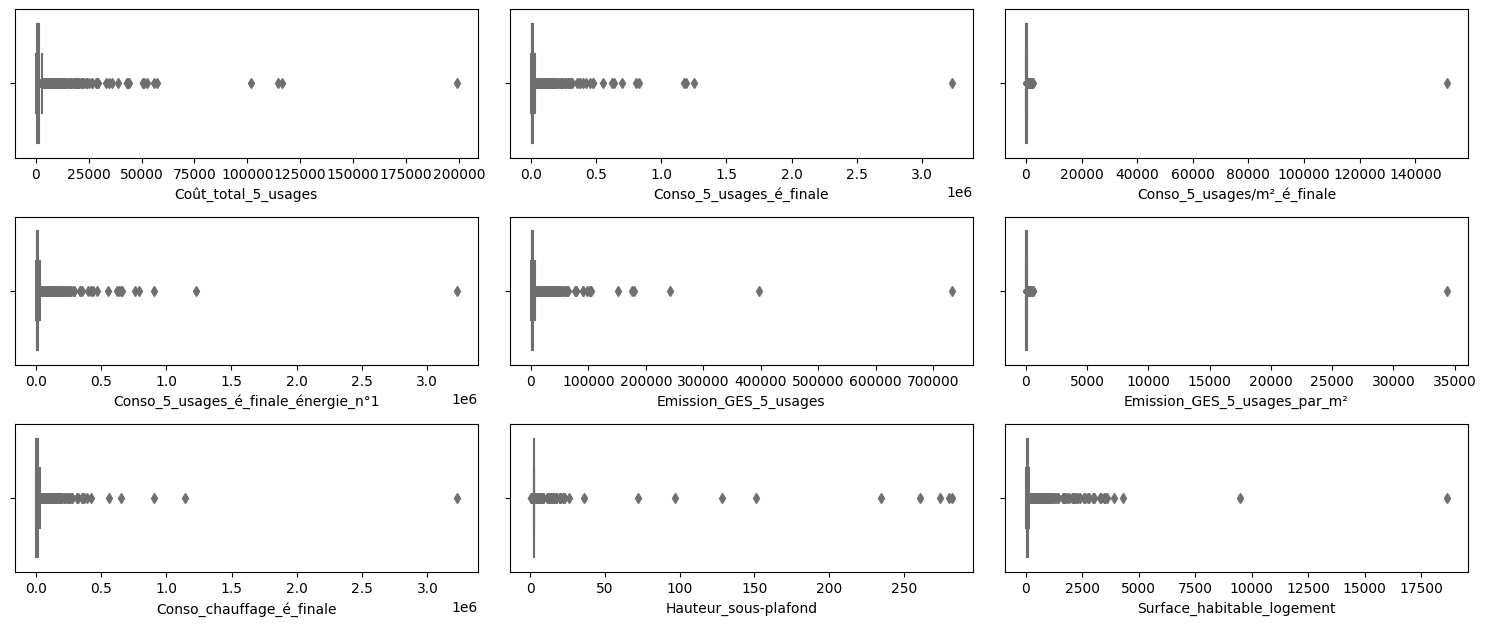

In [10]:
continuous_variables =['Coût_total_5_usages','Conso_5_usages_é_finale','Conso_5_usages/m²_é_finale','Conso_5_usages_é_finale_énergie_n°1', 'Emission_GES_5_usages','Emission_GES_5_usages_par_m²','Conso_chauffage_é_finale','Hauteur_sous-plafond','Surface_habitable_logement']

eda.boxplot(df,continuous_variables)

On remarque que toutes les variables contiennent des valeurs aberrantes très élevées par rapport aux autres valeurs, cela risque d’impacter la modélisation, mais on ne va pas les supprimer puisqu’il s’agit bien des logements existants, et leur suppression conduit à une sous-estimation de la consommation de la consommation et du volume des émissions dans certains logements. On va alors remplacer les valeurs très élevées par (q3 + 3.5 * iqr) et les valeurs très faibles par (q3 - 3.5 * iqr) avec q1 et q3 sont le premier et le troisième quantile, et iqr est la différence entre les deux.

In [11]:
# Détection du nombre des valeurs aberrantes par la méthode des quantiles

eda.Outliers(df,continuous_variables)

,variable,nombre_val_aberrantes
0,Coût_total_5_usages,1049
0,Conso_5_usages_é_finale,1035
0,Conso_5_usages/m²_é_finale,185
0,Conso_5_usages_é_finale_énergie_n°1,1000
0,Emission_GES_5_usages,1341
0,Emission_GES_5_usages_par_m²,198
0,Conso_chauffage_é_finale,1061
0,Hauteur_sous-plafond,16040
0,Surface_habitable_logement,1212


In [12]:
df["Hauteur_sous-plafond"].describe()

count    74131.000000
mean         2.579729
std          2.381128
min          0.400000
25%          2.500000
50%          2.500000
75%          2.500000
max        282.000000
Name: Hauteur_sous-plafond, dtype: float64

In [13]:
df = eda.remplacer_outliers(df,continuous_variables)

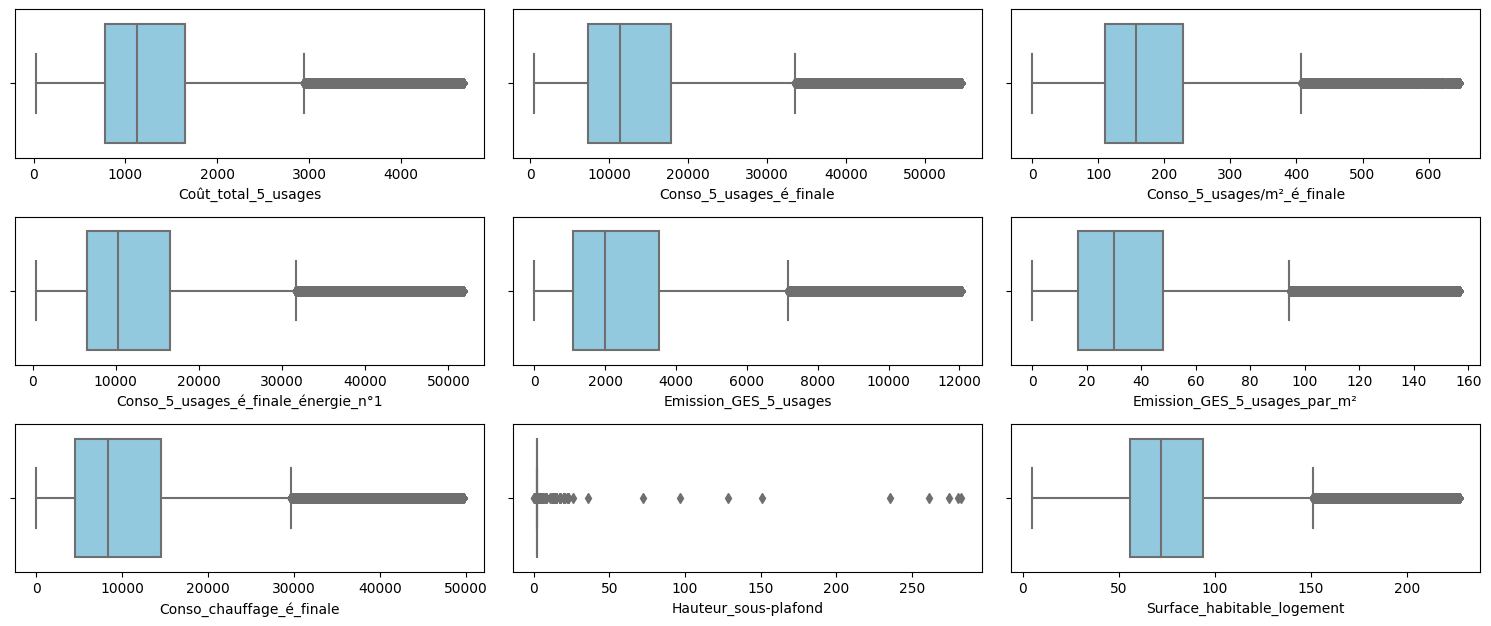

In [14]:
eda.boxplot(df,continuous_variables)

On choisit de prédire directement la consommation de l’énergie et le volume des émissions par m² puisque ces deux variables contiennent le minimum de valeurs aberrantes. Les variables explicatives continues sont la surface du logement, la hauteur sous plafond et le coût de la consommation totale de l’énergie.

In [15]:
# Standardisation des variables  explicatives continues

scaler = StandardScaler()
continuous_explicative = ["Surface_habitable_logement","Hauteur_sous-plafond" ,'Coût_total_5_usages']
df[continuous_explicative] = scaler.fit_transform(df[continuous_explicative])

In [16]:
# Corrélation entre les variables continues 

corr = df.loc[:,["Surface_habitable_logement","Hauteur_sous-plafond","Conso_5_usages/m²_é_finale","Emission_GES_5_usages_par_m²",'Coût_total_5_usages']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Surface_habitable_logement,Hauteur_sous-plafond,Conso_5_usages/m²_é_finale,Emission_GES_5_usages_par_m²,Coût_total_5_usages
Surface_habitable_logement,1.000000,0.016636,-0.070053,-0.098619,0.684730
Hauteur_sous-plafond,0.016636,1.000000,0.024327,0.027579,0.030062
Conso_5_usages/m²_é_finale,-0.070053,0.024327,1.000000,0.837521,0.516882
Emission_GES_5_usages_par_m²,-0.098619,0.027579,0.837521,1.000000,0.465032
Coût_total_5_usages,0.684730,0.030062,0.516882,0.465032,1.000000


On remarque une forte corrélation positive entre la consommation énergétique et le volume des émissions de gaz à effet de serre.
Ces deux variables ont les mêmes corrélations avec les variables explicatives retenus. Nous pouvons envisager de prédire l’une à partir de l’autre.\
La variable Hauteur_sous_plafond est peu corrélées avec les variables cibles, en plus, le traitement de ses valeurs aberrantes est difficile, on va alors l’exclure.

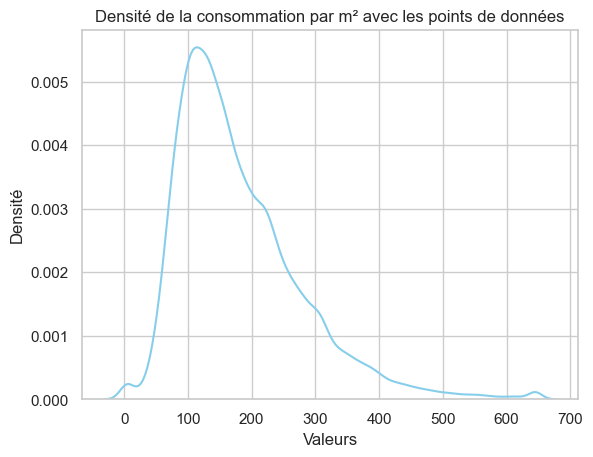

279.45


In [17]:

sns.set(style="whitegrid")
sns.kdeplot(df["Conso_5_usages/m²_é_finale"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

print(df["Conso_5_usages/m²_é_finale"].max()-df["Conso_5_usages/m²_é_finale"].quantile(0.95))

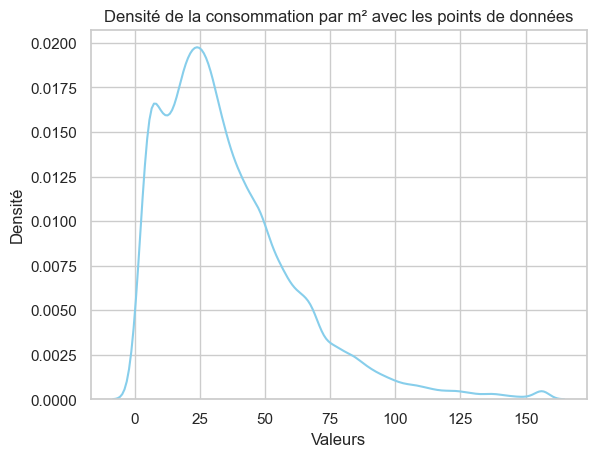

71.5


In [18]:
sns.set(style="whitegrid")
sns.kdeplot(df["Emission_GES_5_usages_par_m²"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

print(df["Emission_GES_5_usages_par_m²"].max()-df["Emission_GES_5_usages_par_m²"].quantile(0.95))

On remarque que la différence entre le 0.95 quantile et la valeur maximale prise par chaque variable est très élevée (279 pour la consommation et 71.5 pour le volume des émissions), les valeurs qui tombent dans cet intervalle risquent d’tre mal prédites par les modèles. 

## Variables catégorielles

In [19]:
categorical_variables = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Etiquette_GES',
                  'Etiquette_DPE',                 # 7 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Période_construction',          # 10 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques 
                  'Qualité_isolation_enveloppe',    # 4 valeurs uniques 
                  'Qualité_isolation_menuiseries',  # 4 valeurs uniques 
                  'Qualité_isolation_murs',         # 4 valeurs uniques 
                  'Qualité_isolation_plancher_bas', # 4 valeurs uniques 
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS',           # 3 valeurs uniques
                  ]      

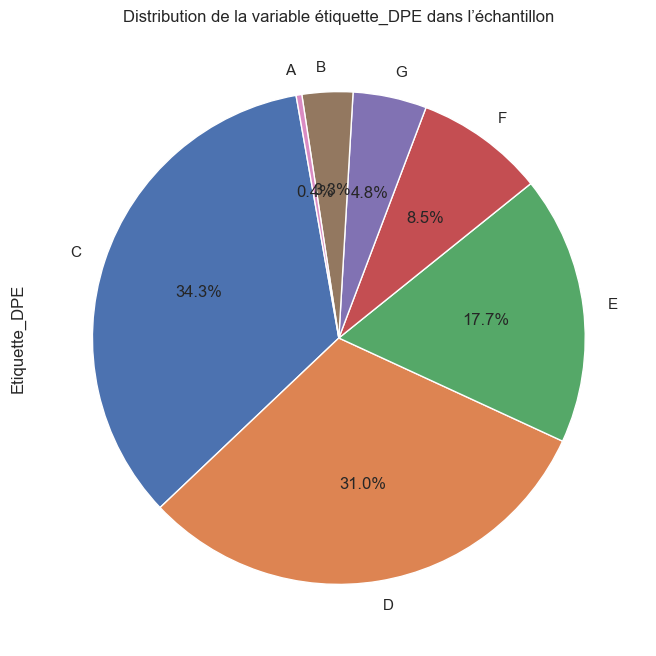

In [20]:
# Distribution des étiquettes DPE 

occurences = df['Etiquette_DPE'].value_counts()

plt.figure(figsize=(8,8))
occurences.plot.pie(autopct='%1.1f%%', startangle=100)
plt.title("Distribution de la variable étiquette_DPE dans l’échantillon")
plt.show()


On explore en détail les variables qui prennent plusieurs valeurs uniques, cela nous aide à trouver un moyen pour les encoder et réduire la complexité du modèle.

In [21]:
categorical_variables1 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                    ]

In [22]:
df['Type_énergie_n°2'].value_counts()

Électricité                                                     56152
Gaz naturel                                                      8136
Bois – Bûches                                                    5553
Fioul domestique                                                 1366
Bois – Granulés (pellets) ou briquettes                          1062
Réseau de Chauffage urbain                                        861
Électricité d'origine renouvelable utilisée dans le bâtiment      651
GPL                                                               324
Bois – Plaquettes forestières                                      11
Charbon                                                             8
Propane                                                             3
Butane                                                              3
Bois – Plaquettes d’industrie                                       1
Name: Type_énergie_n°2, dtype: int64

In [23]:
# Encodage de la variable 'Type_énergie_n°2'

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes'], 'Bois')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Fioul domestique",'GPL'], 'Énergies polluantes')


On remarque que certaines sources d’énergie sont surreprésentées (Electricité, Bois – Bûches  et Gaz naturel), nous allons donc garder ces trois catégories, et on créera deux autres catégories: la première contient le Fioul Domestique et le GPL comme étant les sources les plus polluantes, et la deuxième regroupe l’électricité d’origine renouvelable et le réseau de chauffage urbain. Nous allons faire de meme avec le type d’énergie 1 et l’énergie utilisée pour le chauffage.

In [24]:
df['Type_énergie_n°1'].value_counts()

Gaz naturel                                                     38743
Électricité                                                     13898
Réseau de Chauffage urbain                                      10026
Fioul domestique                                                 4056
Bois – Bûches                                                    3079
GPL                                                              3021
Bois – Granulés (pellets) ou briquettes                           985
Électricité d'origine renouvelable utilisée dans le bâtiment      150
Bois – Plaquettes forestières                                      69
Bois – Plaquettes d’industrie                                      60
Charbon                                                            29
Propane                                                            15
Name: Type_énergie_n°1, dtype: int64

In [25]:
# Encodage de la variable 'Type_énergie_n°1'

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(["Fioul domestique",'GPL','Propane'], 'Énergies polluantes')

In [26]:
df['Type_énergie_principale_chauffage'].value_counts()

Gaz naturel                                                     43880
Réseau de Chauffage urbain                                      10822
Électricité                                                      7670
Fioul domestique                                                 5260
GPL                                                              3089
Bois – Bûches                                                    2220
Bois – Granulés (pellets) ou briquettes                           943
Bois – Plaquettes forestières                                      69
Bois – Plaquettes d’industrie                                      60
Propane                                                            51
Électricité d'origine renouvelable utilisée dans le bâtiment       35
Charbon                                                            32
Name: Type_énergie_principale_chauffage, dtype: int64

In [27]:
# Encodage de la variable 'Type_énergie_principale_chauffage'

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(["Fioul domestique",'GPL','Propane'], 'Énergies polluantes')

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

### OneHotEncoding pour certaines variables catégorielles

### Encodage ordinal pour les variables représentant une hiérarchie naturelle entre les différentes valeurs
Pour les qualités d’isolation, on crée une variable qui prend 0 si l’isolation est insuffisante et 3 si elle est très bonne.\
Pour la période de construction aussi, on crée une variable qui prend les valeurs entre 0 et 9, plus le logement est récent, plus le chiffre est élevé.

In [28]:
df["Période_construction"] = df["Période_construction"].map({"avant 1948":0, "1948-1974":1, "1975-1977":2, "1983-1988":3, '2013-2021':4,'1989-2000':5, '2001-2005':6, '2006-2012':7, '1978-1982':8, 'après 2021':9})

df['Qualité_isolation_plancher_bas'] = df["Qualité_isolation_plancher_bas"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_murs"] = df["Qualité_isolation_murs"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df['Qualité_isolation_enveloppe'] = df["Qualité_isolation_enveloppe"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_menuiseries"] = df["Qualité_isolation_menuiseries"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})


In [29]:
categorical_variables2 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques  
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS']           # 3 valeurs uniques

onehotencoded = eda.one_hot_encode(df,categorical_variables2)

Maintenant, on récupère la base de données finale qu’on va utiliser pour la prédiction.

In [30]:
variables_retenues = ['Période_construction',
                  #'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Conso_5_usages/m²_é_finale',
                  'Emission_GES_5_usages_par_m²',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_n°1_Gaz naturel',
                  'Type_énergie_n°1_Électricité', 
                  'Type_énergie_n°1_Énergies polluantes',
                  'Type_énergie_n°1_Énergies propres', 
                  'Type_énergie_n°2_Gaz naturel',
                  'Type_énergie_n°2_Électricité', 
                  'Type_énergie_n°2_Énergies polluantes',
                   'Type_énergie_n°2_Énergies propres', 
                   #'Type_bâtiment_immeuble',
                   'Type_bâtiment_maison', 
                   'Classe_altitude_inférieur à 400m',
                   'Classe_altitude_supérieur à 800m', 
                   'Zone_climatique__H1b',
                   'Zone_climatique__H1c', 
                   'Zone_climatique__H2a', 
                   'Zone_climatique__H2b',
                   'Zone_climatique__H2c', 
                   'Zone_climatique__H2d', 
                   'Zone_climatique__H3',
                    'Type_énergie_principale_chauffage_Gaz naturel',
                   'Type_énergie_principale_chauffage_Électricité',
                    'Type_énergie_principale_chauffage_Énergies polluantes',
                    'Type_énergie_principale_chauffage_Énergies propres',
                    'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
                    'Type_installation_ECS_installation individuelle',
                    'Coût_total_5_usages']

df_finale = onehotencoded.loc[:,variables_retenues]
df_finale.columns

Index(['Période_construction', 'Surface_habitable_logement',
       'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres', 'Type_énergie_n°2_Gaz naturel',
       'Type_énergie_n°2_Électricité', 'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Classe_altitude_supérieur à 800m',
       'Zone_climatique__H1b', 'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c', 'Zone_climatique__H2d',
       'Zone_climatique__H3', 'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergi

In [31]:
df_finale.shape

(74131, 33)

In [32]:
df_finale.columns

Index(['Période_construction', 'Surface_habitable_logement',
       'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres', 'Type_énergie_n°2_Gaz naturel',
       'Type_énergie_n°2_Électricité', 'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Classe_altitude_supérieur à 800m',
       'Zone_climatique__H1b', 'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c', 'Zone_climatique__H2d',
       'Zone_climatique__H3', 'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergi

In [33]:
df_finale.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74131 entries, 1 to 149986
Data columns (total 33 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   Période_construction                                                                                 74131 non-null  int64  
 1   Surface_habitable_logement                                                                           74131 non-null  float64
 2   Conso_5_usages/m²_é_finale                                                                           74131 non-null  float64
 3   Emission_GES_5_usages_par_m²                                                                         74131 non-null  float64
 4   Qualité_isolation_enveloppe                                                                          7413

# Modélisation

Dans ce qui suit, notre objectif est d’attribuer une étiquette DPE au logement en se basant sur ses caractéristaiques. On va d’abord estimer la consommation de l’énergie à partir des différentes variables traitées avant, ensuite, on utilisera les valeurs obtenues pour estimer le volume des émissions des gaz à effet de serre. Finalement, on va déterminer l’étiquette DPE en fonction des valeurs obtenues, la méthode de classification est résumée dans le tableau suivant:



<img src="img.png"  width="1000" height="600">


## Prédiction de la condommation de l’énergie par an et par m²

### Régularisation de Lasso

In [34]:
df_finale.shape

(74131, 33)

In [35]:


X = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²'], axis = 'columns')
y = df_finale['Conso_5_usages/m²_é_finale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)  # Spécifiez une liste d'alphas à essayer
lasso_cv.fit(X_train, y_train)

# Afficher l'alpha optimal sélectionné par la validation croisée
best_alpha = lasso_cv.alpha_
print(f"Meilleur alpha : {best_alpha}")



Meilleur alpha : 0.001


In [36]:

# Initialiser le modèle LassoCV pour sélectionner automatiquement le meilleur alpha
alpha = 0.001
lasso_model = sklearn.linear_model.Lasso(alpha)

# Entraîner le modèle sur les données d'entraînement
lasso_model.fit(X_train, y_train)

# Afficher les coefficients non nuls (variables sélectionnées)
model = SelectFromModel(lasso_model, prefit=True).fit(X_train, y_train)
X_new = model.transform(X)

model.get_feature_names_out()

array(['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
   

In [37]:
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages']

In [38]:
X = df_finale[selected_features]

# Premier modèle: régression linéaire

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:


lm = make_pipeline(linear_model.LinearRegression())
lm.fit(X_train,y_train)

precision = lm.score(X_train,y_train)
print("La précision du modèle:", precision)

La précision du modèle: 0.7240563891133771


In [41]:
y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)


L’erreur moyenne absolue pour les données d’entrainement: 34.256733626210384
L’erreur moyenne absolue pour les données du test: 33.80369201869084


## Deuxième modèle: régression polynomiale

In [42]:


poly_model = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())


In [43]:
poly_model.fit(X_train,y_train)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [44]:
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
score = r2_score(y_train, y_pred_train)

print("Le score du modèle:", score)
print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

Le score du modèle: 0.8469728242895819
L’erreur moyenne absolue pour les données d’entrainement: 23.700042222815256
L’erreur moyenne absolue pour les données du test: 23.91737179679372


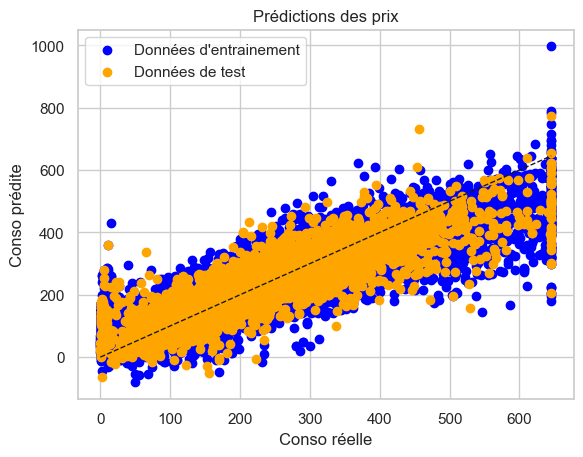

In [45]:
plt.scatter(y_train, y_pred_train, c="blue", label="Données d'entrainement")
plt.scatter(y_test, y_pred_test, c="orange", label="Données de test")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
plt.xlabel('Conso réelle')
plt.ylabel('Conso prédite')
plt.title('Prédictions de la consommation')
plt.legend()
plt.show()

In [46]:
df["conso_predite"] = poly_model.predict(X)

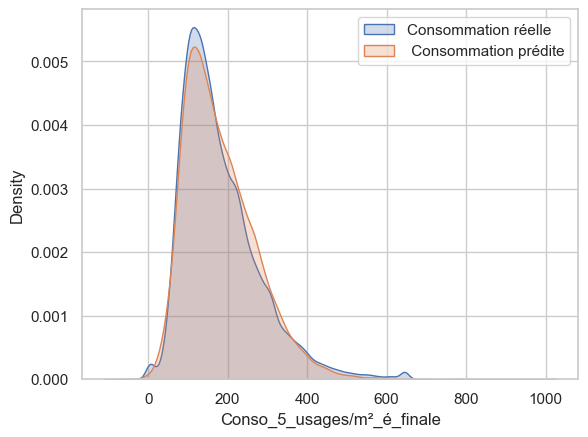

In [47]:
sns.kdeplot(data=df, x='Conso_5_usages/m²_é_finale', fill='Conso_5_usages/m²_é_finale', label="Consommation réelle")
sns.kdeplot(data=df, x="conso_predite", fill="conso_predite", label=" Consommation prédite")
plt.legend()

In [48]:
df["erreurs_conso"] = df["Conso_5_usages/m²_é_finale"]-df["conso_predite"]

In [49]:
df["erreurs_conso"].describe()

count    74131.000000
mean        -0.047460
std         38.276697
min       -414.324110
25%        -16.108015
50%         -1.083532
75%         13.651388
max        464.469073
Name: erreurs_conso, dtype: float64

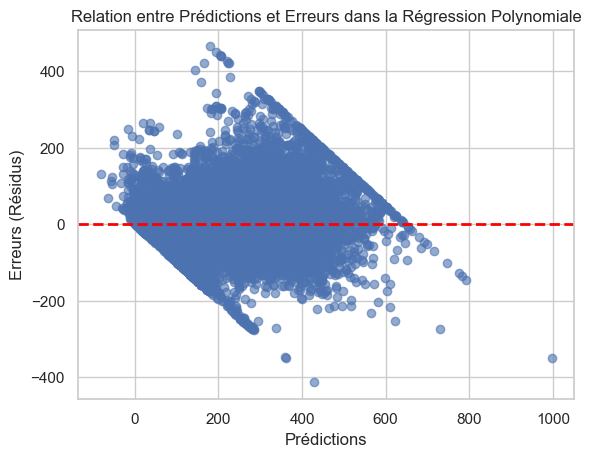

In [50]:
plt.scatter(df["conso_predite"], df["erreurs_conso"], alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Ligne à zéro pour référence
plt.xlabel('Prédictions')
plt.ylabel('Erreurs (Résidus)')
plt.title('Relation entre Prédictions et Erreurs dans la Régression Polynomiale')
plt.show()

# Prédiction des émissions de gaz à effet de serre

## Régularisation de Lasso

In [51]:
df_finale["conso_predite_normalisee"] = scaler.fit_transform(df[['conso_predite']])
X_e = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²'], axis = 'columns')
y_e = df_finale['Emission_GES_5_usages_par_m²']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)  # Spécifiez une liste d'alphas à essayer
lasso_cv.fit(X, y)

# Afficher l'alpha optimal sélectionné par la validation croisée
best_alpha = lasso_cv.alpha_
print(f"Meilleur alpha : {best_alpha}")

Meilleur alpha : 0.001


In [52]:
# Initialiser le modèle LassoCV pour sélectionner automatiquement le meilleur alpha
alpha = 0.001
lasso_model = sklearn.linear_model.Lasso(alpha)

# Entraîner le modèle sur les données d'entraînement
lasso_model.fit(X_train_e, y_train_e)

# Afficher les coefficients non nuls (variables sélectionnées)
model = SelectFromModel(lasso_model, prefit=True).fit(X_e, y_e)

model.get_feature_names_out()

array(['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
   

In [53]:

selected_features_e = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages', 'conso_predite_normalisee']

In [54]:
X_e = df_finale[selected_features_e]

In [55]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)

In [56]:
lm_e = linear_model.LinearRegression()
lm_e.fit(X_train_e,y_train_e)

precision = lm_e.score(X_train_e,y_train_e)
print("La précision du modèle:", precision)

La précision du modèle: 0.778356706763855


In [57]:
y_pred_test_e = lm_e.predict(X_test_e)
y_pred_train_e = lm_e.predict(X_train_e)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_e, y_pred_train_e)
mae_test = mean_absolute_error(y_test_e, y_pred_test_e)

print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)


L’erreur moyenne absolue pour les données d’entrainement: 7.962577649501742
L’erreur moyenne absolue pour les données du test: 8.06464657008189


## Deuxième modèle

In [58]:
poly_model_e = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())

In [59]:
poly_model_e.fit(X_train_e,y_train_e)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [60]:
y_pred_test_e = poly_model_e.predict(X_test_e)
y_pred_train_e = poly_model_e.predict(X_train_e)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_e, y_pred_train_e)
mae_test = mean_absolute_error(y_test_e, y_pred_test_e)
score = r2_score(y_train_e, y_pred_train_e)

print("Le score du modèle:", score)
print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

Le score du modèle: 0.8478586829473914
L’erreur moyenne absolue pour les données d’entrainement: 6.130123494510064
L’erreur moyenne absolue pour les données du test: 6.215962795675097


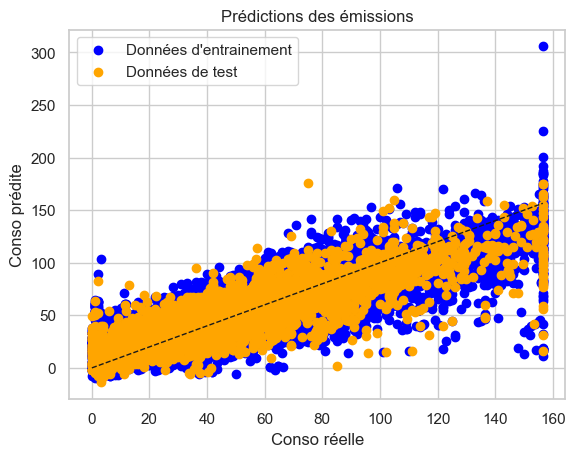

In [61]:
plt.scatter(y_train_e, y_pred_train_e, c="blue", label="Données d'entrainement")
plt.scatter(y_test_e, y_pred_test_e, c="orange", label="Données de test")
plt.plot([y_e.min(), y_e.max()], [y_e.min(), y_e.max()], 'k--', lw=1)
plt.xlabel('Conso réelle')
plt.ylabel('Conso prédite')
plt.title('Prédictions des émissions')
plt.legend()
plt.show()

In [62]:
df["emission_predite"] = poly_model_e.predict(X_e)

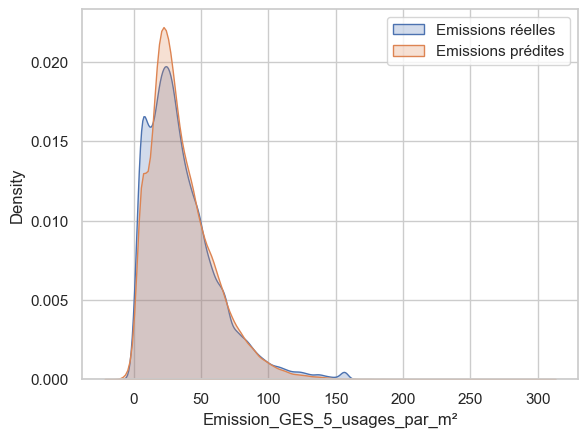

In [63]:
sns.kdeplot(data=df, x='Emission_GES_5_usages_par_m²', fill='Emission_GES_5_usages_par_m²', label="Emissions réelles")
sns.kdeplot(data=df, x="emission_predite", fill="emission_predite", label="Emissions prédites")
plt.legend()

In [86]:
def remplissage (row):
    if row["conso_predite_s"]<70 and row["emission_predite_s"]<6 :
        return "A"
    elif row["conso_predite_s"]<110 and row["emission_predite_s"]<11 :
        return "B"
    elif row["conso_predite_s"]<180 and row["emission_predite_s"]<30 :
        return "C"
    elif row["conso_predite_s"]<250 and row["emission_predite_s"]<50 :
        return "D"
    elif row["conso_predite_s"]<330 and row["emission_predite_s"]<70 :
        return "E"
    elif row["conso_predite_s"]<420 and row["emission_predite_s"]<100 :
        return "F"
    else:
        return "G"

In [65]:
df["etiquette_predite"] = df.apply(remplissage,axis=1)

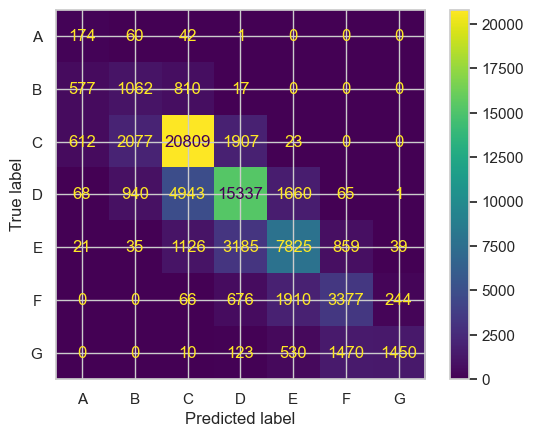

In [66]:
ConfusionMatrixDisplay.from_predictions(df["Etiquette_DPE"], df["etiquette_predite"])

In [67]:
accuracy = accuracy_score(df["Etiquette_DPE"], df["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.67


# Modélisation

## Prédiction simultanée de la consommation de l’énergie et du volume des émissions de gaz à effet de serre par m² et par an

### Régression Lasso

In [68]:

X_s = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²',"conso_predite_normalisee"], axis = 'columns')
y_s = df_finale.loc[:,['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²']]

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

lasso_cv = MultiTaskLassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)  # Spécifiez une liste d'alphas à essayer
lasso_cv.fit(X_train, y_train)

# Afficher l'alpha optimal sélectionné par la validation croisée
best_alpha = lasso_cv.alpha_
print(f"Meilleur alpha : {best_alpha}")

Meilleur alpha : 0.001


In [69]:
alpha = 0.001
lasso_model = sklearn.linear_model.Lasso(alpha)

# Entraîner le modèle sur les données d'entraînement
lasso_model.fit(X_train, y_train)

# Afficher les coefficients non nuls (variables sélectionnées)
model = SelectFromModel(lasso_model, prefit=True).fit(X_train, y_train)

# Affichage des variables sélectionnées par la régression Lasso
model.get_feature_names_out()

array(['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
   

In [70]:
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages']

In [71]:
X_s = df_finale[selected_features]

In [72]:
X_s = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²'], axis = 'columns')
y_s = df_finale.loc[:,['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²']]

In [73]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

### Régression linéaire

In [92]:
lm = linear_model.LinearRegression()
lm.fit(X_train_s,y_train_s)

precision = lm.score(X_train_s,y_train_s)
print("La précision du modèle:", precision)

La précision du modèle: 0.812664770770814


In [93]:
y_pred_test = lm.predict(X_test_s)
y_pred_train = lm.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train)
mae_test = mean_absolute_error(y_test_s, y_pred_test)

print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

L’erreur moyenne absolue pour les données d’entrainement: 15.83124391826495
L’erreur moyenne absolue pour les données du test: 15.990979137411179


### Régression polynomiale

In [124]:

poly_model = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2), linear_model.LinearRegression())

In [125]:
poly_model.fit(X_train_s,y_train_s)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [ ]:
y_pred_test_s = poly_model.predict(X_test_s)
y_pred_train_s = poly_model.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train_s)
mae_test = mean_absolute_error(y_test_s, y_pred_test_s)
score = r2_score(y_train_s, y_pred_train_s)

print("Le score du modèle:", score)
print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

Le score du modèle: 0.8601108985319315
L’erreur moyenne absolue pour les données d’entrainement: 13.424462935086154
L’erreur moyenne absolue pour les données du test: 13.536365627845354


Il n’y a pas un overfitting dans le modèle

In [ ]:
predictions = poly_model.predict(X_s)
df['conso_predite_s'] = [predictions[i][0] for i in  range(0,74131)]
df['emission_predite_s'] = [predictions[i][1] for i in  range(0,74131)]

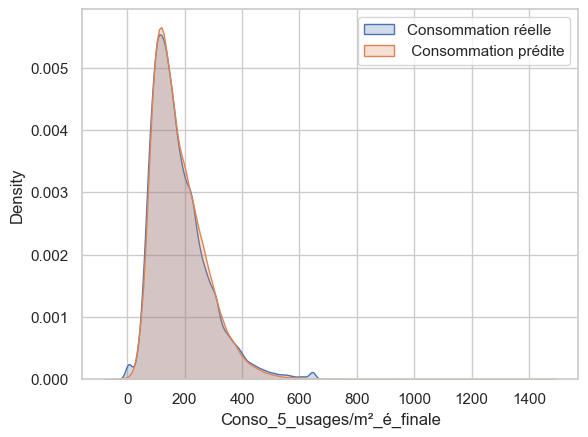

In [ ]:
sns.kdeplot(data=df, x='Conso_5_usages/m²_é_finale', fill='Conso_5_usages/m²_é_finale', label="Consommation réelle")
sns.kdeplot(data=df, x="conso_predite_s", fill="conso_predite_s", label=" Consommation prédite")
plt.legend()

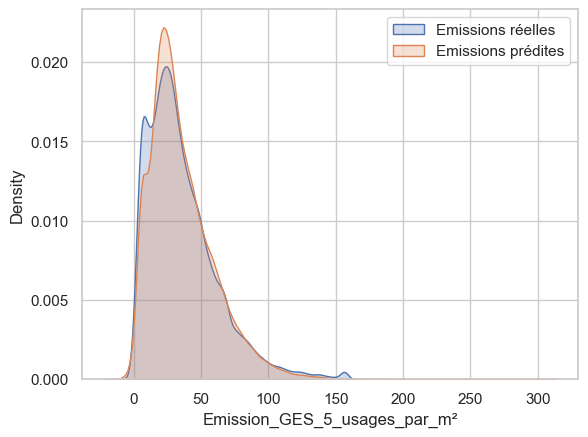

In [ ]:
sns.kdeplot(data=df, x='Emission_GES_5_usages_par_m²', fill='Emission_GES_5_usages_par_m²', label="Emissions réelles")
sns.kdeplot(data=df, x="emission_predite_s", fill="emission_predite_s", label="Emissions prédites")
plt.legend()

Analyse des erreurs

In [ ]:
df["etiquette_predite"] = df.apply(remplissage,axis=1)

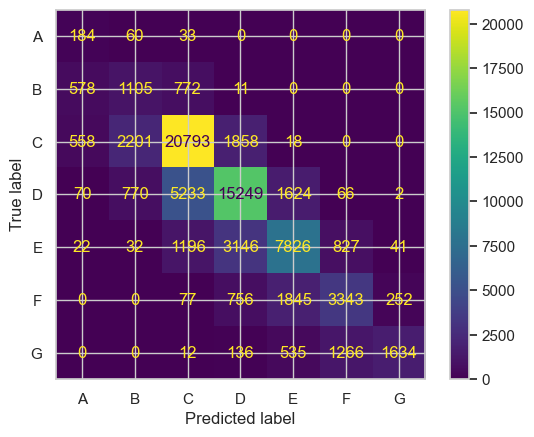

In [ ]:
ConfusionMatrixDisplay.from_predictions(df["Etiquette_DPE"], df["etiquette_predite"])

In [ ]:
accuracy = accuracy_score(df["Etiquette_DPE"], df["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.68


Nous avons essayé d’autres modèles:
* ElasticNet: accuracy=0.6 et mauvaise prédiction des valeurs extrêmes 

# CE QUI SUIT EST A IGNORER


## Mise en place de la base de données exploitable.

L'objectif est de selectionner et de modifier certaines variables afin qu'elles puissent etre utilisées efficacement dans nos analyses.


In [ ]:
# Traitement des données manquantes

# Suppression des colonnes avec plus de 60% des valeurs manquantes
df.drop(["Type_énergie_n°3","Isolation_toiture_(0/1)", "_score"], axis=1, inplace=True)

# Suppression des lignes dans lesquelles la surface habitable est non renseignée
df=df[df["Surface_habitable_logement"].notna()]
df=df[df["Qualité_isolation_plancher_bas"].notna()]

# Pour les données qui ont Type_énergie_principale_ECS=Nan ou Type_énergie_principale_chauffage=Nan, on remplit ces cases par Type_énergie_n°1
df["Type_énergie_principale_ECS"].fillna(df["Type_énergie_n°1"], inplace = True)
df["Type_énergie_principale_chauffage"].fillna(df["Type_énergie_n°1"], inplace = True)

# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_chauffage' par 'bois'
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')
# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_ECS' par 'bois'
df['Type_énergie_principale_ECS'] = df['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

# La simulation portera uniquement sur les maisons et les appartements, on supprime les immeubles
df=df[df["Type_bâtiment"]!="immeuble"]

# L’encodage des variables non numériques
label_encoder = LabelEncoder()
df['Qualité_isolation_plancher_bas_encoded'] = label_encoder.fit_transform(df['Qualité_isolation_plancher_bas'])
df["Qualité_isolation_murs_encoded"] = label_encoder.fit_transform(df['Qualité_isolation_murs'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df["Type_énergie_principale_ECS_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_ECS'])
df["Type_énergie_principale_chauffage_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_chauffage'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df = pd.get_dummies(df, columns=['Type_bâtiment'])

df

KeyError: "['Type_énergie_n°3', 'Isolation_toiture_(0/1)', '_score'] not found in axis"

In [ ]:
df['Qualité_isolation_plancher_bas'].unique()

array([3, 1, 0, 2], dtype=int64)

## OLD

In [ ]:
# Importation des bibliothèques qu’on va utiliser

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Le simulateur de DPE en fonction d’informations accessibles pour le propriétaire et le locataire: 

## Mise en place de la base de données exploitable. 
L'objectif est de selectionner et de modifier certaines variables afin qu'elles puissent etre utilisées efficacement dans nos analyses.

In [ ]:
# Traitement des données manquantes

# Suppression des colonnes avec plus de 60% des valeurs manquantes
df.drop(["Type_énergie_n°3","Isolation_toiture_(0/1)", "_score"], axis=1, inplace=True)

# Suppression des lignes dans lesquelles la surface habitable est non renseignée
df=df[df["Surface_habitable_logement"].notna()]
df=df[df["Qualité_isolation_plancher_bas"].notna()]

# Pour les données qui ont Type_énergie_principale_ECS=Nan ou Type_énergie_principale_chauffage=Nan, on remplit ces cases par Type_énergie_n°1
df["Type_énergie_principale_ECS"].fillna(df["Type_énergie_n°1"], inplace = True)
df["Type_énergie_principale_chauffage"].fillna(df["Type_énergie_n°1"], inplace = True)

# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_chauffage' par 'bois'
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')
# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_ECS' par 'bois'
df['Type_énergie_principale_ECS'] = df['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

# La simulation portera uniquement sur les maisons et les appartements, on supprime les immeubles
df=df[df["Type_bâtiment"]!="immeuble"]

# L’encodage des variables non numériques
label_encoder = LabelEncoder()
df['Qualité_isolation_plancher_bas_encoded'] = label_encoder.fit_transform(df['Qualité_isolation_plancher_bas'])
df["Qualité_isolation_murs_encoded"] = label_encoder.fit_transform(df['Qualité_isolation_murs'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df["Type_énergie_principale_ECS_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_ECS'])
df["Type_énergie_principale_chauffage_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_chauffage'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df = pd.get_dummies(df, columns=['Type_bâtiment'])

df



KeyError: "['Type_énergie_n°3', 'Isolation_toiture_(0/1)', '_score'] not found in axis"

In [ ]:
df['Qualité_isolation_plancher_bas'].unique()

array(['très bonne', 'insuffisante', 'bonne', 'moyenne'], dtype=object)

## Analyse descriptive de la base de donnée : 
- répartition des types d'énergies principaux des logements ?
- type de chauffage utilisé en majorité selon la note de l'étiquette DPE ? 
- etiquette DPE en fonction des codes postaux (représentation cartographique ? ) rq => ajouter dans la base de donnéee les données géo
- etiquette DPE en fonction de l'année de construction ?
- surface habitable 

rq :  quels sont les variables cibles dans la base ? on cherche a prédri les consos, les émissions etc... Objectifs avec ces variables est de faire un indicateur de performanace énergétiques et ensuite de le prédire. 

Méthodologie => se baser sur la litterature pour comprendre les indicateurs majeur de performance énergetique, création de l'indice en attribuant des poids aux varaibles cibles, les normaliser ? moyenne ? 




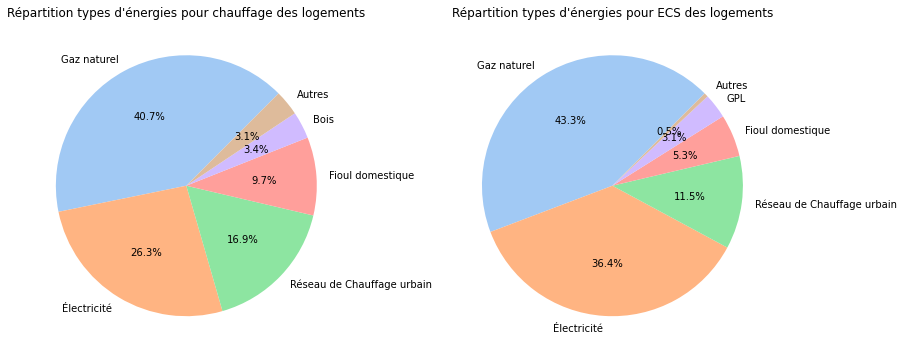

In [ ]:
# Analyse descriptive de la base de donnée : 
bd_dpe = df.copy()

# répartition des types d'energies de chauffage  des logements : 
comptage_type_energie = bd_dpe['Type_énergie_principale_chauffage'].value_counts()


### REPRESENTATION GRAPHIQUE 
# Calcul des pourcentages pour chaque type d'énergie
pourcentages_chauffage = (comptage_type_chauffage / len(bd_dpe)) * 100
pourcentages_ECS = (comptage_type_ECS / len(bd_dpe)) * 100

# Seuil pour regrouper les petites catégories sous "Autres"
seuil = 3

# Regroupement des petites catégories sous "Autres" si leur pourcentage est inférieur au seuil
autres_chauffage = pourcentages_chauffage[pourcentages_chauffage < seuil].sum()
autres_ECS = pourcentages_ECS[pourcentages_ECS < seuil].sum()

# Création de nouveaux tableaux pour le graphique avec "Autres"
nouveaux_pourcentages_chauffage = pourcentages_chauffage[pourcentages_chauffage >= seuil]
nouveaux_pourcentages_chauffage['Autres'] = autres_chauffage

nouveaux_pourcentages_ECS = pourcentages_ECS[pourcentages_ECS >= seuil]
nouveaux_pourcentages_ECS['Autres'] = autres_ECS

# Création des graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graphique pour le chauffage
axes[0].pie(x=nouveaux_pourcentages_chauffage, labels=nouveaux_pourcentages_chauffage.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_chauffage)), autopct='%1.1f%%')
axes[0].set_title('Répartition types d\'énergies pour chauffage des logements')

# Graphique pour l'ECS
axes[1].pie(x=nouveaux_pourcentages_ECS, labels=nouveaux_pourcentages_ECS.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_ECS)), autopct='%1.1f%%')
axes[1].set_title('Répartition types d\'énergies pour ECS des logements')

# Affichage des graphiques
plt.show()


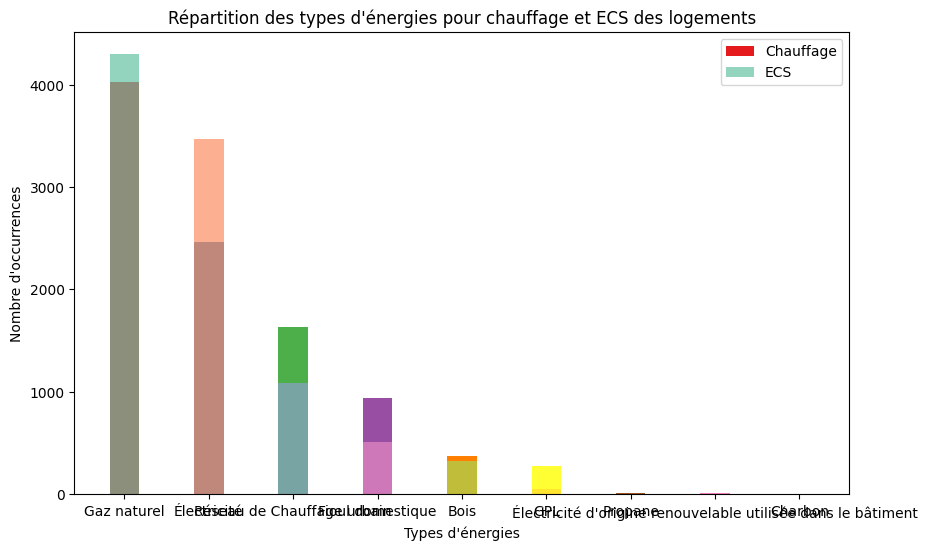

In [ ]:

# TYPE DE REPRESENTATIONA REVOIR /!\ pas tres visuelle

# Comptage pour 'Type_énergie_principale_chauffage'
comptage_type_chauffage = bd_dpe['Type_énergie_principale_chauffage'].value_counts()
colors_ECS = sns.color_palette('Set2')[0:len(comptage_type_ECS)]

# Comptage pour 'type_principale_energie_ECS'
comptage_type_ECS = bd_dpe['Type_énergie_principale_ECS'].value_counts()
colors_chauffage = sns.color_palette('Set1')[0:len(comptage_type_chauffage)]

# Création du graphique en barres superposées
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comptage_type_chauffage))

# Barres pour 'Type_énergie_principale_chauffage'
plt.bar(index, comptage_type_chauffage, bar_width, color=colors_chauffage, label='Chauffage')

# Barres pour 'type_principale_energie_ECS'
plt.bar(index, comptage_type_ECS, bar_width, color=colors_ECS, label='ECS', alpha=0.7)

# Ajout des labels, titres, et légende
plt.xlabel('Types d\'énergies')
plt.ylabel('Nombre d\'occurrences')
plt.title('Répartition des types d\'énergies pour chauffage et ECS des logements')
plt.xticks(index, comptage_type_chauffage.index)
plt.legend()

# Affichage du graphique
plt.show()

## GEOLOCALISATION : 
Repésentation géographique des données à l'aide de géopandas 

In [ ]:
# debut des explorations

In [ ]:
create_unique(df)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values
0,Type_énergie_n°1,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."
0,Type_énergie_n°2,object,10,1684,"[Bois – Bûches, Électricité, Gaz naturel, nan,..."
0,Type_ventilation,object,36,3112,More than 15 unique values
0,Qualité_isolation_plancher_bas,object,4,0,"[très bonne, insuffisante, moyenne, bonne]"
0,Qualité_isolation_murs,object,4,0,"[insuffisante, bonne, très bonne, moyenne]"
0,Hauteur_sous-plafond,float64,39,0,More than 15 unique values
0,Surface_habitable_logement,float64,1683,0,More than 15 unique values
0,Code_postal_(brut),object,2856,0,More than 15 unique values
0,Période_construction,object,10,0,"[avant 1948, 1948-1974, 1975-1977, 2006-2012, ..."
0,Type_énergie_principale_ECS,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."


Analyse de corrélations (via des graphes et probablement une carte)

In [ ]:
# Répartition des données entre données d’entrainement et celles de validation
x=df.iloc[:,[5,6,7,12,13,14,15,16,17,19,20]]
y=df["Etiquette_DPE"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)


In [ ]:
#instanciation
model_DT = DecisionTreeClassifier()
#training
model_DT.fit(X_train, y_train)
#Prédiction
prediction = model_DT.predict(X_test)
# Evaluation
print(model_DT.score(X_train, y_train))
print(model_DT.score(X_test, y_test))

scores = cross_val_score(model_DT, x, y, cv=5)
print(scores)

# MAUVAISE PERFORMANCE (OVERFITTING)


0.990755535265921
0.4948665297741273
[0.50256674 0.48741654 0.49357987 0.46533128 0.47817155]


In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Vous pouvez ajuster les hyperparamètres selon vos besoins

# Entraînez le classificateur sur l'ensemble d'entraînement
clf.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluez les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# A REVOIR, JE COMPRENDS PAS TROP CES GRANDEURS

Accuracy: 0.5523613963039015
Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         6
           B       0.70      0.50      0.58        32
           C       0.73      0.73      0.73       332
           D       0.50      0.60      0.54       284
           E       0.43      0.41      0.42       189
           F       0.30      0.25      0.27        72
           G       0.39      0.22      0.28        59

    accuracy                           0.55       974
   macro avg       0.43      0.39      0.40       974
weighted avg       0.55      0.55      0.55       974

Confusion Matrix:
[[  0   2   3   1   0   0   0]
 [  0  16  11   5   0   0   0]
 [  1   3 243  67  17   1   0]
 [  0   1  61 171  38  11   2]
 [  0   1   9  68  77  22  12]
 [  0   0   2  20  26  18   6]
 [  0   0   3  12  23   8  13]]
